In [1]:
import gym
from gym import spaces
from gym.utils import seeding
from tqdm import tqdm

In [2]:
import pandas as pd
import numpy as np
import typing
from datetime import datetime

In [7]:
import ray
# Start up Ray. This must be done before we instantiate any RL agents.
ray.init(num_cpus=10, ignore_reinit_error=True, log_to_driver=False,_temp_dir="/rds/general/user/asm119/ephemeral")

2020-12-02 10:48:07,690	ERROR worker.py:660 -- Calling ray.init() again after it has already been called.


In [8]:
Thomas_data = "../Thomas/"
def load_data(
    price_source: str, 
    tickers: typing.List[str],
    start: datetime, 
    end: datetime, 
    features: typing.List[str],
):
    """Returned price data to use in gym environment"""
    # Load data
    # Each dataframe will have columns date and a collection of fields
    # TODO: DataLoader from mongoDB
    # Raw price from DB, forward impute on the trading days for missing date
    # calculate the features (log return, volatility)
    if price_source in ["csvdata"]:
        feature_df = []
        for t in tickers:
            df1 = pd.read_csv(Thomas_data + "csvdata/{}.csv".format(t))
            df1['datetime'] = pd.to_datetime(df1['datetime'])
            df1 = df1[(df1['datetime']>=start) & (df1['datetime']<=end)]
            df1.set_index("datetime",inplace=True)
            selected_features = ['return','tcost'] + features
            feature_df.append(df1[selected_features])
            ref_df_columns = df1[selected_features].columns

    # assume all the price_df are aligned and cleaned in the DataLoader
    merged_df = pd.concat(feature_df, axis=1, join="outer")
    # Imputer missing values with zeros 
    price_tensor = merged_df['return'].fillna(0.0).values
    tcost = merged_df['tcost'].fillna(0.0).values

    return {
        "dates": merged_df.index,
        "fields": ref_df_columns,
        "data": merged_df.fillna(0.0).values,
        "pricedata": price_tensor,
        "tcost": tcost,
    }


In [9]:
load_data('csvdata',['SPY','QQQ',], datetime(2010, 5, 4), datetime(2020, 12, 31), ["volatility_20", "skewness_20", "kurtosis_20"] ) ['data'][:10,:]

array([[-2.36998991e-02,  4.25369008e-05,  1.09934270e-02,
        -9.14812793e-01, -2.61064489e-01, -3.01849936e-02,
         1.03231135e-04,  1.16465557e-02, -1.10048552e+00,
         5.96949184e-01],
       [-5.94984959e-03,  4.27953952e-05,  1.09991806e-02,
        -9.10788716e-01, -2.70376218e-01, -5.12061786e-03,
         1.03745202e-04,  1.16723407e-02, -9.95452223e-01,
         4.23777969e-01],
       [-3.36369023e-02,  4.42928644e-05,  1.30807177e-02,
        -9.16682320e-01, -2.54900342e-01, -3.36202334e-02,
         0.00000000e+00,  1.37192261e-02, -9.68839072e-01,
        -4.24718444e-02],
       [-1.49229482e-02,  4.49216118e-05,  1.31754036e-02,
        -7.10326792e-01, -5.75516042e-01, -2.49435926e-02,
         0.00000000e+00,  1.45399702e-02, -7.26873145e-01,
        -6.77999658e-01],
       [ 4.29173814e-02,  4.30496362e-05,  1.66156842e-02,
         3.64864054e-01,  7.49281745e-01,  5.01088321e-02,
         1.04701078e-04,  1.85963149e-02,  4.85487538e-01,
         1.

In [10]:
from empyrical import max_drawdown, alpha_beta, sharpe_ratio, annual_return
from sklearn.preprocessing import StandardScaler 

class Equitydaily(gym.Env):

    def __init__(self,env_config):
        
        self.tickers = env_config['tickers']
        self.lookback = env_config['lookback']
        self.random_start = env_config['random_start']
        self.trading_days = env_config['trading_days'] # Number of days the algorithm runs before resetting
        # Load price data, to be replaced by DataLoader class
        raw_data = load_data(env_config['pricing_source'],env_config['tickers'],env_config['start'],env_config['end'],env_config['features'])
        # Set the trading dates, features and price data 
        self.dates = raw_data['dates']
        self.fields = raw_data['fields']
        self.pricedata = raw_data['pricedata']
        self.featuredata = raw_data['data']
        self.tcostdata = raw_data['tcost']
        # Set up historical actions and rewards 
        self.n_assets = len(self.tickers) + 1
        self.n_metrics = 2 
        self.n_assets_fields = len(self.fields)
        self.n_features = self.n_assets_fields * len(self.tickers) + self.n_assets + self.n_metrics # reward function
        #self.n_features = self.n_assets_fields * len(self.tickers)
        
        # Set up action and observation space
        # The last asset is cash 
        self.action_space = spaces.Box(low=-1, high=1, shape=(len(self.tickers)+1,), dtype=np.float32)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf,
                                            shape=(self.lookback,self.n_features,1), dtype=np.float32)

        self.reset()

        

    def step(self, action):
        
        # Trade every 10 days 
        # Normalise action space 
        if (self.index - self.start_index) % 10 == 0:
            normalised_action = action / np.sum(np.abs(action))
            self.actions = normalised_action
        
        done = False
        # Rebalance portfolio at close using return of the next date
        next_day_log_return = self.pricedata[self.index,:]
        # transaction cost 
        transaction_cost = self.transaction_cost(self.actions,self.position_series[-1])
        
        # Rebalancing 
        self.position_series = np.append(self.position_series, [self.actions], axis=0)
        # Portfolio return 
        today_portfolio_return = np.sum(self.actions[:-1] * next_day_log_return) + np.sum(transaction_cost)
        self.log_return_series = np.append(self.log_return_series, [today_portfolio_return], axis=0)
        
        
        # Calculate reward 
        # Need to cast log_return in pd series to use the functions in empyrical 
        recent_series = pd.Series(self.log_return_series)[-100:]
        #print(recent_series)
        rolling_volatility = np.std(recent_series)
        self.metric = today_portfolio_return / rolling_volatility 
        reward = self.metric
        self.metric_series = np.append(self.metric_series, [self.metric], axis=0)
        
        # Check if the end of backtest
        if self.trading_days is None:
            done = self.index >= self.pricedata.shape[0]-2
        else:
            done = (self.index - self.start_index) >= self.trading_days
            
        # Prepare observation for next day
        self.index += 1
        self.observation = self.get_observation()
            
        return self.observation, reward, done, {}
    
    
    def reset(self):
        self.log_return_series = np.zeros(shape=self.lookback)
        self.metric_series = np.zeros(shape=self.lookback)
        self.position_series = np.zeros(shape=(self.lookback,self.n_assets))
        self.metric = 0           
        if self.random_start:
            num_days = len(self.dates)      
            self.start_index = np.random.randint(self.lookback, num_days - self.trading_days)
            self.index = self.start_index
        else:
            self.start_index = self.lookback
            self.index = self.lookback
        self.actions = np.zeros(shape=self.n_assets)
        self.observation = self.get_observation()
        return self.observation
    
    def get_observation(self):
        # Can use simple moving average data here 
        last_lookback_day = self.index - self.start_index
        price_lookback = self.featuredata[last_lookback_day:last_lookback_day + self.lookback,:]
        metrics = np.vstack((self.log_return_series[last_lookback_day:last_lookback_day + self.lookback], 
                             self.metric_series[last_lookback_day:last_lookback_day + self.lookback])).transpose()
        positions = self.position_series[last_lookback_day:last_lookback_day + self.lookback]
        scaler = StandardScaler()
        price_lookback = scaler.fit_transform(price_lookback)
        observation = np.concatenate((price_lookback, metrics, positions), axis=1)
        return observation.reshape((observation.shape[0], observation.shape[1], 1))
    
    # 0.05% and spread to model t-cost for institutional portfolios 
    def transaction_cost(self, new_action, old_action):
        turnover = np.abs(new_action - old_action) 
        fees = 0.9995 - self.tcostdata[self.index,:]
        fees = np.array(list(fees) + [0.9995])
        tcost = turnover * np.log(fees)
        return tcost 

In [42]:
"""
Set the training env to use random starts as made by Pavol, 506 trading days (2 years of trading) and only before the year 2014. Everything after that will be used as a dev set.
We use a 60 day look back as used here https://www.oxford-man.ox.ac.uk/wp-content/uploads/2020/06/Deep-Reinforcement-Learning-for-Trading.pdf.
This isn't gospel. It's a starting point

The conv-net filters had beef with using different look back values for this. Instead I used 150 lookback. 
Will work on fixing this ^^^



"""
agent_training_config = {'pricing_source':'csvdata', 'tickers':['BRK','TLT','QQQ','GLD',], 
          'lookback':150, 'start':'2008-01-02', 'end':'2013-12-31', 'features':["volatility_20", "skewness_20", "kurtosis_20"], 'random_start': True, 'trading_days':506}


In [28]:
EQ_env.reset()
_, rw, _, _ = EQ_env.step([ 0.4612986,  -0.3883527,  -0.45688114, -0.06747285, -0.1717046])
print(rw)

NameError: name 'EQ_env' is not defined

PPO policy

In [38]:
from ray.rllib.agents.ppo import PPOTrainer, DEFAULT_CONFIG
from ray.tune.logger import pretty_print

In [43]:
#train the model using only the training data

config = DEFAULT_CONFIG.copy()
config['num_workers'] = 1
config["num_envs_per_worker"] = 1
config["rollout_fragment_length"] = 20
config["train_batch_size"] = 1200
config["batch_mode"] = "complete_episodes"
config['num_sgd_iter'] = 20
config['sgd_minibatch_size'] = 200
config['model']['dim'] = 200
config['model']['conv_filters'] = [[32, [5, 1], 5], [32, [5, 1], 5], [4, [5, 1], 5]]
config['num_cpus_per_worker'] = 2  # This avoids running out of resources in the notebook environment when this cell is re-executed
config['env_config'] = agent_training_config

Check to see if agents can be trained

In [47]:
agent = PPOTrainer(config, Equitydaily)
best_reward = -np.inf

2020-12-02 11:01:44,185	INFO trainable.py:255 -- Trainable.setup took 12.396 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2020-12-02 11:01:44,187	WARNING util.py:40 -- Install gputil for GPU system monitoring.


In [48]:
for i in tqdm(range(500)):
    result = agent.train()
    if result['episode_reward_mean'] > best_reward + 10:
        path = agent.save('./sampleagent2')
        print(path)
        best_reward = result['episode_reward_mean']
        print(best_reward)

  0%|          | 1/500 [00:07<1:02:36,  7.53s/it]

./sampleagent2/checkpoint_1/checkpoint-1
-0.8334105702757029


 42%|████▏     | 212/500 [24:18<33:26,  6.97s/it]

./sampleagent2/checkpoint_212/checkpoint-212
10.267246339594443


100%|██████████| 500/500 [57:12<00:00,  6.87s/it]


In [49]:
for i in tqdm(range(500)):
    result = agent.train()
    if result['episode_reward_mean'] > best_reward:
        path = agent.save('./sampleagent2')
        print(path)
        best_reward = result['episode_reward_mean']
        print(best_reward)

  0%|          | 1/500 [00:06<56:41,  6.82s/it]

./sampleagent2/checkpoint_501/checkpoint-501
15.561175765060936


  0%|          | 2/500 [00:13<57:26,  6.92s/it]

./sampleagent2/checkpoint_502/checkpoint-502
16.66653162031688


  1%|          | 3/500 [00:20<57:01,  6.88s/it]

./sampleagent2/checkpoint_503/checkpoint-503
18.061766068087042


  1%|          | 5/500 [00:34<56:50,  6.89s/it]

./sampleagent2/checkpoint_505/checkpoint-505
18.292634865000586


  1%|▏         | 7/500 [00:48<57:32,  7.00s/it]

./sampleagent2/checkpoint_507/checkpoint-507
18.63445928911157


 24%|██▍       | 121/500 [17:48<47:13,  7.48s/it]

./sampleagent2/checkpoint_621/checkpoint-621
18.867799569485722


 25%|██▍       | 123/500 [18:02<45:41,  7.27s/it]

./sampleagent2/checkpoint_623/checkpoint-623
19.279517452782656


 25%|██▍       | 124/500 [18:14<54:21,  8.67s/it]

./sampleagent2/checkpoint_624/checkpoint-624
19.34254519081022


 30%|██▉       | 149/500 [21:11<39:35,  6.77s/it]

./sampleagent2/checkpoint_649/checkpoint-649
19.48789861380361


 33%|███▎      | 165/500 [22:58<37:31,  6.72s/it]

./sampleagent2/checkpoint_665/checkpoint-665
19.942959687174955


 49%|████▊     | 243/500 [31:54<30:25,  7.10s/it]

./sampleagent2/checkpoint_743/checkpoint-743
20.158063416750117


 49%|████▉     | 244/500 [32:01<30:19,  7.11s/it]

./sampleagent2/checkpoint_744/checkpoint-744
20.262916709238606


 49%|████▉     | 247/500 [32:22<29:17,  6.94s/it]

./sampleagent2/checkpoint_747/checkpoint-747
20.32055430125345


 50%|████▉     | 248/500 [32:28<28:47,  6.85s/it]

./sampleagent2/checkpoint_748/checkpoint-748
20.61400946546529


 50%|████▉     | 249/500 [32:35<28:50,  6.89s/it]

./sampleagent2/checkpoint_749/checkpoint-749
21.339960114932506


 50%|█████     | 252/500 [32:55<27:53,  6.75s/it]

./sampleagent2/checkpoint_752/checkpoint-752
21.41509295569854


 51%|█████     | 254/500 [33:08<27:22,  6.68s/it]

./sampleagent2/checkpoint_754/checkpoint-754
22.116784994504705


 51%|█████     | 256/500 [33:22<27:25,  6.74s/it]

./sampleagent2/checkpoint_756/checkpoint-756
22.23996244813605


 52%|█████▏    | 258/500 [33:36<27:23,  6.79s/it]

./sampleagent2/checkpoint_758/checkpoint-758
22.923258559009472


 52%|█████▏    | 259/500 [33:43<27:16,  6.79s/it]

./sampleagent2/checkpoint_759/checkpoint-759
23.195352802116428


 53%|█████▎    | 267/500 [34:39<27:43,  7.14s/it]

./sampleagent2/checkpoint_767/checkpoint-767
23.212487013856308


 99%|█████████▊| 493/500 [1:01:00<00:47,  6.78s/it]

./sampleagent2/checkpoint_993/checkpoint-993
23.54382351484487


 99%|█████████▉| 494/500 [1:01:06<00:40,  6.72s/it]

./sampleagent2/checkpoint_994/checkpoint-994
23.950490082010315


100%|██████████| 500/500 [1:01:47<00:00,  7.42s/it]


In [55]:
for i in tqdm(range(500)):
    result = agent.train()
    if result['episode_reward_mean'] > best_reward + 5:
        path = agent.save('./sampleagent2')
        print(path)
        best_reward = result['episode_reward_mean']
        print(best_reward)

 79%|███████▉  | 395/500 [45:08<12:00,  6.86s/it]


RayActorError: The actor died unexpectedly before finishing this task.

# Training set run

In [56]:
"""
Config an environment with the full training set data without random starts

"""
training_config = {'pricing_source':'csvdata', 'tickers':['BRK','TLT','QQQ','GLD',], 
          'lookback':150, 'start':'2008-01-02', 'end':'2013-12-31', 'features':["volatility_20", "skewness_20", "kurtosis_20"], 'random_start': False, 'trading_days':506}


In [57]:
train_env = Equitydaily(training_config)

<AxesSubplot:>

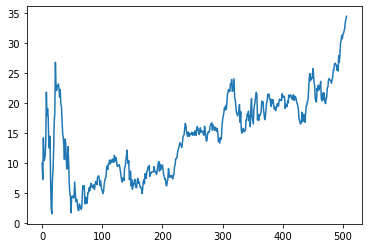

In [58]:
state = train_env.reset()
done = False
reward_list = []
cum_reward = 0
actions = list()

while not done:
    #action = agent.compute_action(state)
    action = agent.compute_action(state)
    state, reward, done, future_price = train_env.step(action)
    cum_reward += reward
    actions.append(action)
    reward_list.append(reward)

pd.Series(reward_list).cumsum().plot()

# Dev set run

In [59]:
dev_config = {'pricing_source':'csvdata', 'tickers':['BRK','TLT','QQQ','GLD',], 
          'lookback':150, 'start':'2014-01-01', 'end':'2016-12-31', 'features':["volatility_20", "skewness_20", "kurtosis_20"], 'random_start': False, 'trading_days':506}
dev_env = Equitydaily(dev_config)

<AxesSubplot:>

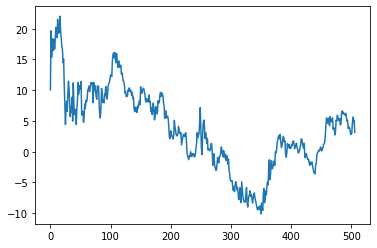

In [60]:
state = dev_env.reset()
done = False
reward_list = []
cum_reward = 0
actions = list()

while not done:
    #action = agent.compute_action(state)
    action = agent.compute_action(state)
    state, reward, done, future_price = dev_env.step(action)
    cum_reward += reward
    actions.append(action)
    reward_list.append(reward)

pd.Series(reward_list).cumsum().plot()

In [ ]:
agent.restore('sampleagent/checkpoint_1/checkpoint-1')

In [ ]:
for i in range(5):
    result = agent.train()
    if result['episode_reward_mean'] > best_reward + 1:
        path = agent.save('sampleagent')
        print(path)
        best_reward = result['episode_reward_mean']
        print(best_reward)

In [ ]:
result

SAC 

In [ ]:
from ray.rllib.agents.sac import SACTrainer, DEFAULT_CONFIG
from ray.tune.logger import pretty_print

In [ ]:
config = DEFAULT_CONFIG.copy()
config['num_workers'] = 1
config["num_envs_per_worker"] = 1

config["rollout_fragment_length"] = 10
config["train_batch_size"] = 50
config["timesteps_per_iteration"] = 10
config["buffer_size"] = 10000

config["Q_model"]["fcnet_hiddens"] = [10, 10]
config["policy_model"]["fcnet_hiddens"] = [10, 10]
config["num_cpus_per_worker"] = 2 
config["env_config"] = {
    "pricing_source": "csvdata",
    "tickers": ["QQQ", "EEM", "TLT", "SHY", "GLD", "SLV"],
    "lookback": 1,
    "start": "2007-01-02",
    "end": "2015-12-31",
}

In [ ]:
# Train agent 
agent = SACTrainer(config, Equitydaily)
best_reward = -np.inf

In [ ]:
for i in range(20):
    result = agent.train()
    if result['episode_reward_mean'] > best_reward + 0.01:
        path = agent.save('sampleagent')
        print(path)
        best_reward = result['episode_reward_mean']
    print(result['episode_reward_mean'])

In [ ]:
result

Run environment 

In [ ]:
config

In [ ]:
agent = PPOTrainer(config, Equitydaily)

In [ ]:
env = Equitydaily(config['env_config'])

In [ ]:
agent.restore('checkpoint_1087/checkpoint-1087')

In [ ]:
state = env.reset()
done = False
reward_list = []
cum_reward = 0
actions = list()

while not done:
    #action = agent.compute_action(state)
    action = np.array([0,0,0,0,0,0,1])
    state, reward, done, _ = env.step(action)
    cum_reward += reward
    actions.append(action)
    reward_list.append(reward)

pd.Series(env.log_return_series).cumsum().plot()

In [ ]:
pd.Series(reward_list).plot()

In [ ]:
pd.DataFrame(actions)

Run environment for RNN environment

In [ ]:
env = Equitydaily({'pricing_source':'Alpaca_Equity_daily', 'tickers':['SPY','QQQ'], 'lookback':50, 'start':'2018-01-02', 'end':'2020-12-31'})

state = env.reset()
done = False
cum_reward = 0 
actions = list()

rnn_state = agent.get_policy().get_initial_state()

while not done:
    action, rnn_state, _ = agent.compute_action(state,rnn_state)
    #action = np.array([1,-1])
    state, reward, done, _ = env.step(action)
    cum_reward += reward
    actions.append(actions)

pd.Series(env.log_return_series).cumsum().plot()

In [ ]:
max_drawdown(pd.Series(env.log_return_series))

In [ ]:
annual_return(pd.Series(env.log_return_series))

In [ ]:
class Equitydaily_v1(gym.Env):

    def __init__(self,env_config):
        
        self.tickers = env_config['tickers']
        self.lookback = env_config['lookback']
        # Load price data, to be replaced by DataLoader class
        raw_data = load_data(env_config['pricing_source'],env_config['tickers'],env_config['start'],env_config['end'])
        # Set the trading dates, features and price data 
        self.dates = raw_data['dates']
        self.fields = raw_data['fields']
        self.pricedata = raw_data['pricedata']
        self.featuredata = raw_data['data']
        self.tcostdata = raw_data['tcost']
        # Set up historical actions and rewards 
        self.n_assets = len(self.tickers) + 1
        self.n_metrics = 2 
        self.n_assets_fields = len(self.fields)
        self.n_features = self.n_assets_fields * len(self.tickers) + self.n_assets + self.n_metrics # reward function
        
        # Set up action and observation space
        # The last asset is cash 
        self.action_space = spaces.Box(low=-1, high=1, shape=(len(self.tickers)+1,), dtype=np.float32)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf,
                                            shape=(self.lookback,self.n_features), dtype=np.float32)

        self.reset()

        

    def step(self, action):
        
        ## Normalise action space 
        normalised_action = action / np.sum(np.abs(action))
        
        done = False
        # Rebalance portfolio at close using return of the next date
        next_day_log_return = self.pricedata[self.index,:]
        # transaction cost 
        transaction_cost = self.transaction_cost(normalised_action,self.position_series[-1])
        
        # Rebalancing 
        self.position_series = np.append(self.position_series, [normalised_action], axis=0)
        # Portfolio return 
        today_portfolio_return = np.sum(normalised_action[:-1] * next_day_log_return) + np.sum(transaction_cost)
        self.log_return_series = np.append(self.log_return_series, [today_portfolio_return], axis=0)
        
        
        # Calculate reward 
        # Need to cast log_return in pd series to use the functions in empyrical 
        live_days = self.index - self.lookback
        burnin = 250
        recent_series = pd.Series(self.log_return_series)[-100:]
        whole_series = pd.Series(self.log_return_series)
        if live_days > burnin: 
            self.metric = annual_return(whole_series) + 0.5* max_drawdown(whole_series)
        else:
            self.metric = annual_return(whole_series) + 0.5* max_drawdown(whole_series) *live_days / burnin
        reward = self.metric - self.metric_series[-1]
        #reward = self.metric
        self.metric_series = np.append(self.metric_series, [self.metric], axis=0)
        
        # Check if the end of backtest
        if self.index >= self.pricedata.shape[0]-2:
            done = True
            
        # Prepare observation for next day
        self.index += 1
        self.observation = self.get_observation()
            
        return self.observation, reward, done, {'current_price':next_day_log_return}
    
    
    def reset(self):
        self.log_return_series = np.zeros(shape=self.lookback)
        self.metric_series = np.zeros(shape=self.lookback)
        self.position_series = np.zeros(shape=(self.lookback,self.n_assets))
        self.metric = 0                    
        self.index = self.lookback
        self.observation = self.get_observation()
        return self.observation
    
    def get_observation(self):
        # Can use simple moving average data here 
        price_lookback = self.featuredata[self.index-self.lookback:self.index,:]
        metrics = np.vstack((self.log_return_series[self.index-self.lookback:self.index], 
                             self.metric_series[self.index-self.lookback:self.index])).transpose()
        positions = self.position_series[self.index-self.lookback:self.index]
        observation = np.concatenate((price_lookback, metrics, positions), axis=1)
        return observation 
    
    # 0.05% and spread to model t-cost for institutional portfolios 
    def transaction_cost(self,new_action,old_action,):
        turnover = np.abs(new_action - old_action) 
        fees = 0.9995 - self.tcostdata[self.index,:]
        tcost = turnover * np.log(fees)
        return tcost 